# YouTube trending videos

In [1]:
%matplotlib inline
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from helpers.files import load_csv

plt.rcParams["figure.facecolor"] = "#a9a9a9"
random.seed(0)
np.random.seed(0)


def print_stats(clf, x_train, y_train, x_test, y_test):
    y_train_pred = clf.predict(x_train)
    print(f"Train accuracy: {accuracy_score(y_train, y_train_pred)}")
    y_test_pred = clf.predict(x_test)
    print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")

# X, y = shap.datasets.boston()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#
# # Random Forest
# rf = sklearn.ensemble.RandomForestRegressor()
# rf.fit(X_train, y_train)
#
# # K Nearest Neighbor
# knn = sklearn.neighbors.KNeighborsRegressor()
# knn.fit(X_train, y_train)
#
# # Tree on Random Forest
# explainerRF = shap.TreeExplainer(rf)
# shap_values_RF_test = explainerRF.shap_values(X_test)
# shap_values_RF_train = explainerRF.shap_values(X_train)
#
# # Random Forest
# df_shap_RF_test = pd.DataFrame(shap_values_RF_test, columns=X_test.columns.values)
# df_shap_RF_train = pd.DataFrame(shap_values_RF_train, columns=X_train.columns.values)
#
# categorical_features = np.argwhere(np.array([len(set(X_train.values[:, x]))
#                                              for x in range(X_train.values.shape[1])]) <= 10).flatten()
#
# # LIME has one explainer for all models
# explainer = lime.lime_tabular.LimeTabularExplainer(
#     X_train.values,
#     feature_names=X_train.columns.values.tolist(),
#     class_names=['price'],
#     categorical_features=categorical_features,
#     verbose=True, mode='regression'
# )
#
# j = 0
# # initialize js for SHAP
# shap.initjs()
#
# exp = explainer.explain_instance(X_test.values[j], rf.predict, num_features=5)
# exp.show_in_notebook(show_table=True)
# shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], X_test.iloc[[j]])

### Wczytanie danych

In [2]:
load_filtered =True
if load_filtered:
    videos = load_csv("ped6_filtered_data")[0]
else:
    videos = load_csv("ped6_data")[0]

videos = videos.sample(frac=1).reset_index(drop=True)
videos.head(5)
print(len(videos))

15444


### Przygotowanie danych

Train: (12355, 78)
Test: (3089, 78)


,title_len,channel_title_len,publish_time_day_of_week,publish_time_hour_of_day,gray_mean_score,color_mean_score,edges_score,entropy_score,title_tfidf_10,title_tfidf_2017,...,tags_tfidf_live,tags_tfidf_makeup,tags_tfidf_music,tags_tfidf_new,tags_tfidf_news,tags_tfidf_receta,tags_tfidf_show,tags_tfidf_sport,tags_tfidf_video,tags_tfidf_voic
0,0.711340,0.033898,0.500000,0.913043,0.755512,0.393163,0.464044,0.045361,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.268041,0.135593,0.000000,0.695652,0.492064,0.410999,0.574985,0.068524,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.597938,0.118644,0.333333,0.391304,0.699117,0.703798,0.700061,0.334950,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.379567,0.0
3,0.340206,0.254237,0.000000,0.652174,0.637168,0.557358,0.267363,0.095866,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.474227,0.237288,0.833333,0.869565,0.499700,0.480327,0.470805,0.047946,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


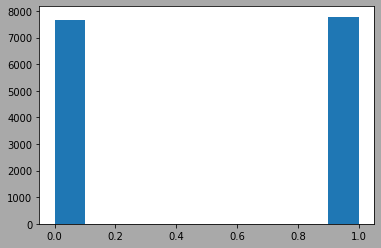

In [3]:
y = videos["trending"]
plt.hist(y)
x = videos.loc[:, videos.columns != "trending"]

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=0)

# y_test = np.where(y_test == 0, 1, 0)

x_train_stats = x_train.mean()

x_train = x_train.fillna(x_train_stats)
x_test = x_test.fillna(x_train_stats)

scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)

print(f"Train: {x_train.shape}")
print(f"Test: {x_test.shape}")
x_train.head(5)

### Wybór miar oceny klasyfikatorów

Accuracy
TODO wyjaśnij wybór.

### Wybór pierwszego klasyfikatora

RandomForest
TODO uzasadnij wybór.

In [4]:
param_grid = {
    "reduce_dim__k": [5, 10, 20, 25, 30],  # range(1, 50, 5),
    "classifier__max_depth": [4, 8, 10],
    "classifier__min_samples_leaf": [1, 2],  # 2, 4],
    "classifier__n_estimators": [10, 50, 100, 200]

}

pipeline = Pipeline([
    ("reduce_dim", SelectKBest(chi2)),
    ("classifier", RandomForestClassifier())
])

grid_search = GridSearchCV(pipeline, n_jobs=8, param_grid=param_grid, cv=10, verbose=1, scoring="accuracy")
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 10, 'reduce_dim__k': 30}



### Uczenie pierwszego klasyfikatora

In [5]:
k = grid_search.best_params_["reduce_dim__k"]
max_depth = grid_search.best_params_["classifier__max_depth"]
min_samples_leaf = grid_search.best_params_["classifier__min_samples_leaf"]
n_estimators = grid_search.best_params_["classifier__n_estimators"]
# Tree on Random Forest
select = SelectKBest(chi2, k=k)

x_train_selected = select.fit_transform(x_train, y_train)
x_test_selected = select.transform(x_test)

mask = select.get_support()
new_features = [feature for supported, feature in zip(mask, x.columns.values) if supported]

x_train_selected = pd.DataFrame(x_train_selected, columns=new_features)
x_test_selected = pd.DataFrame(x_test_selected, columns=new_features)

rf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf
)
rf.fit(x_train_selected, y_train)


RandomForestClassifier(max_depth=10, n_estimators=10)

### Testowanie pierwszego klasyfikatora

In [6]:
print_stats(rf, x_train_selected, y_train, x_test_selected, y_test)
rf_pred = lambda x: rf.predict_proba(x).astype(float)


Train accuracy: 0.7048158640226629
Test accuracy: 0.6992554224668177


### Interpretacja predykcji pierwszego klasyfikatora

Intercept -0.5850359261789383
Prediction_local [0.55835507]
Right: 0.5591783167029114


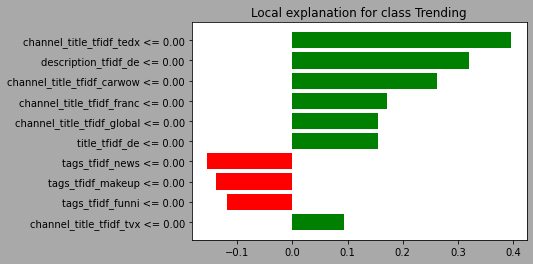

In [7]:
explainerRF = shap.TreeExplainer(rf)

# shap_values_RF_test = explainerRF.shap_values(x_test_selected, approximate=True)
# shap_values_RF_train = explainerRF.shap_values(x_train_selected, approximate=True)
# Random Forest
#TODO check index
# df_shap_RF_test = pd.DataFrame(shap_values_RF_test[1], columns=x_test.columns.values)
# df_shap_RF_train = pd.DataFrame(shap_values_RF_train[1], columns=x_train.columns.values)

# LIME has one explainer for all models
explainer = LimeTabularExplainer(
    x_train_selected.values,
    feature_names=x_train_selected.columns.values.tolist(),
    training_labels=[0, 1],
    class_names=['Non trending', "Trending"],
    verbose=True,
)

j = 0

exp = explainer.explain_instance(x_test_selected.loc[[j]].values[0], rf_pred)
exp.save_to_file("lime.html")
# exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
plt.show(fig)

In [8]:
j = 123
x_test_selected.loc[[j]]

,title_tfidf_de,title_tfidf_en,title_tfidf_la,channel_title_tfidf_carwow,channel_title_tfidf_cocina,channel_title_tfidf_de,channel_title_tfidf_franc,channel_title_tfidf_global,channel_title_tfidf_la,channel_title_tfidf_late,...,tags_tfidf_2018,tags_tfidf_de,tags_tfidf_funni,tags_tfidf_late,tags_tfidf_live,tags_tfidf_makeup,tags_tfidf_new,tags_tfidf_news,tags_tfidf_receta,tags_tfidf_show
123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], x_test.iloc[[j]])
print(y_test.to_numpy()[j])
shap_val = explainerRF.shap_values(x_test_selected.loc[[j]], approximate=True)
print(np.array(shap_val).shape)
# initialize js for SHAP

shap.initjs()
shap.force_plot(explainerRF.expected_value[1], shap_val[1], x_test_selected.loc[[j]])


0
(2, 1, 30)


In [11]:
j = 2000
x_test_selected.loc[[j]]

,title_tfidf_de,title_tfidf_en,title_tfidf_la,channel_title_tfidf_carwow,channel_title_tfidf_cocina,channel_title_tfidf_de,channel_title_tfidf_franc,channel_title_tfidf_global,channel_title_tfidf_la,channel_title_tfidf_late,...,tags_tfidf_2018,tags_tfidf_de,tags_tfidf_funni,tags_tfidf_late,tags_tfidf_live,tags_tfidf_makeup,tags_tfidf_new,tags_tfidf_news,tags_tfidf_receta,tags_tfidf_show
2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [12]:
print(y_test.to_numpy()[j])
# shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], x_test.iloc[[j]])
shap_val = explainerRF.shap_values(x_test_selected.loc[[j]], approximate=True)
print(np.array(shap_val).shape)
# initialize js for SHAP
shap.initjs()
shap.force_plot(explainerRF.expected_value[1], shap_val[1], x_test_selected.loc[[j]])


1
(2, 1, 30)


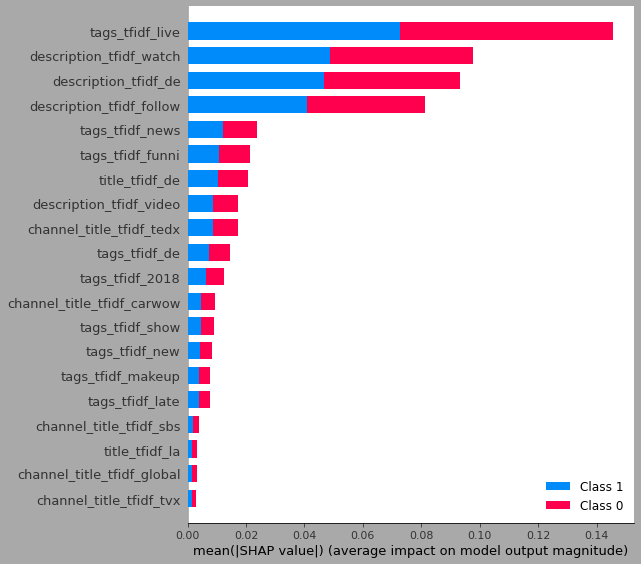

In [13]:
shap.summary_plot(shap_val, x_test_selected.loc[[j]])
# shap.summary_plot(shap_values_RF_train[0], x_train_selected)


# TODO pomyśl o filtrowaniu danych
# TODO pomyśl o odfiltrowaniu innych języków

### Wybór klasyfikatora

### Uczenie klasyfikatora

### Wybór drugiego klasyfikatora

### Testowanie klasyfikatora
### Uczenie drugiego klasyfikatora

### Interpretacja predykcji

### Testowanie drugiego klasyfikatora

### Interpretacja predykcji drugiego klasyfikatora

### Porównanie wyników klasyfikatorów

### Wiedza dla klientasa
Profil harakterystycznych wartości atrybutów dla klasy trending

Co trzeba robić?

Czego się wystrzegać?